## Load libs

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

## Data

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import Subset

batch_size = 128
N = batch_size * 500

In [3]:
# Load the CelebA dataset
transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor()
])

dataset = datasets.CelebA(root='./data', split='train', transform=transform, download=True)
subset = Subset(dataset, range(N))
dataloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


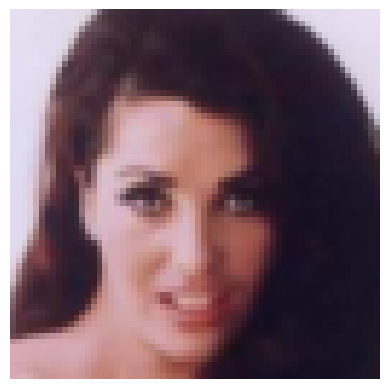

torch.Size([3, 64, 64])

In [4]:
import matplotlib.pyplot as plt

# Select a random image from the dataset
index = 10
image, _ = subset[index]

# Display the image
plt.imshow(image.permute(1, 2, 0))  # convert from tensor to numpy array and rearrange the dimensions
plt.axis('off')
plt.show()

image.shape

## Model def

In [6]:
class VAE(nn.Module):
    def __init__(self, latent_size=20):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        
        # Latent space
        self.fc_mu = nn.Linear(4*4*256, latent_size)
        self.fc_logvar = nn.Linear(4*4*256, latent_size)
        
        # Decoder
        self.fc_decoder = nn.Linear(latent_size, 4*4*256)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def decode(self, z):
        h = self.fc_decoder(z)
        h = h.view(-1, 256, 4, 4)
        x_recon = self.decoder(h)
        return x_recon
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

## Fit model

In [24]:
# Instantiate the VAE
latent_size=32
model = VAE(latent_size)

sum(p.numel() for p in model.parameters())

1777411

In [25]:
# Where to save model
# Change this after updating model definition
model_path = './models/vae_05_0.pth'

In [ ]:
# Load a trained VAE
# model = VAE(latent_size=2)
model.load_state_dict(torch.load('./models/vae_05_0.pth'))

In [26]:
lossi = []

In [27]:
# Define the loss function and optimizer
def loss_fn(x_recon, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

lr = 3e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [57]:
from tqdm.notebook import tqdm # status bar

num_epochs = 1

model.train()
for epoch in range(num_epochs):
    for batch_idx, (images, _) in enumerate(tqdm(dataloader)):
        
        x_recon, mu, logvar = model(images)
        loss = loss_fn(x_recon, images, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_idx+1) % 10 == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                  .format(epoch+1, num_epochs, batch_idx+1, len(dataloader), loss.item()))
        
        lossi.append(loss.log10().item())
        
        if (batch_idx + 1) == 200:
            break
            
# Save the trained VAE
torch.save(model.state_dict(), model_path)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/1], Step [10/500], Loss: 863186.0000
Epoch [1/1], Step [20/500], Loss: 855210.5625
Epoch [1/1], Step [30/500], Loss: 861050.8750
Epoch [1/1], Step [40/500], Loss: 856773.5625
Epoch [1/1], Step [50/500], Loss: 825346.2500
Epoch [1/1], Step [60/500], Loss: 845892.8125
Epoch [1/1], Step [70/500], Loss: 851843.0625
Epoch [1/1], Step [80/500], Loss: 847013.3750
Epoch [1/1], Step [90/500], Loss: 851159.6875
Epoch [1/1], Step [100/500], Loss: 861034.1875
Epoch [1/1], Step [110/500], Loss: 837306.8750
Epoch [1/1], Step [120/500], Loss: 838774.8125
Epoch [1/1], Step [130/500], Loss: 854950.1875
Epoch [1/1], Step [140/500], Loss: 847693.6875
Epoch [1/1], Step [150/500], Loss: 834587.5000
Epoch [1/1], Step [160/500], Loss: 834606.1250
Epoch [1/1], Step [170/500], Loss: 843373.5625
Epoch [1/1], Step [180/500], Loss: 837807.5000
Epoch [1/1], Step [190/500], Loss: 830643.9375
Epoch [1/1], Step [200/500], Loss: 861197.2500


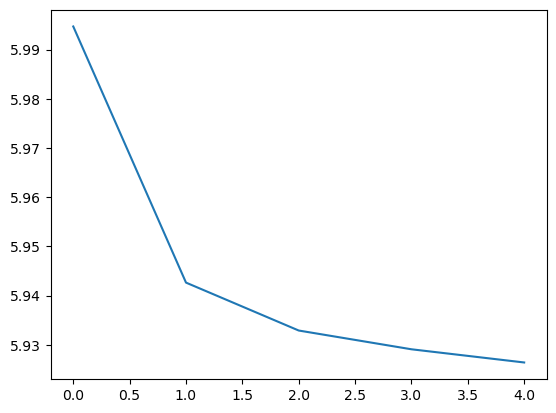

In [58]:
plt.plot(torch.tensor(lossi).view(-1,100).mean(1))

### Show some sampled faces

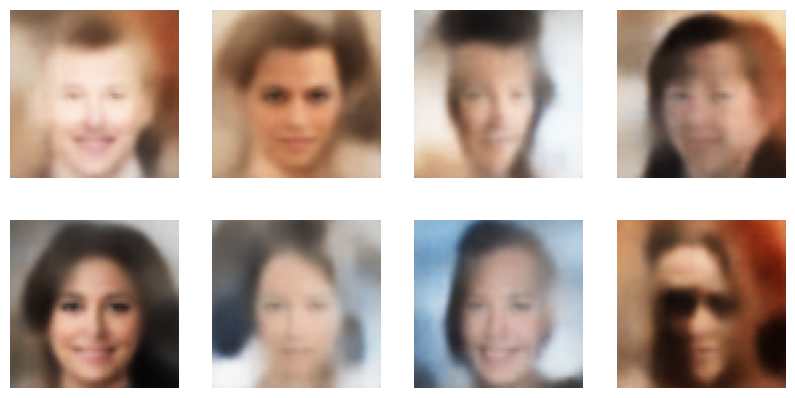

In [64]:
# Load the trained VAE
latent_size = 64
model = VAE(latent_size)
model.load_state_dict(torch.load('./models/vae_03_4.pth'))

# Generate new images
model.eval()
num_images = 8  # 2x4 grid = 8 images
z = torch.randn(num_images, latent_size)
new_images = model.decode(z)

# Display the images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(new_images[i].squeeze().detach().permute(1, 2, 0))  # convert from tensor to numpy array and rearrange the dimensions
    ax.axis('off')
plt.show()

### Show real face vs reconstruction

  0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64])


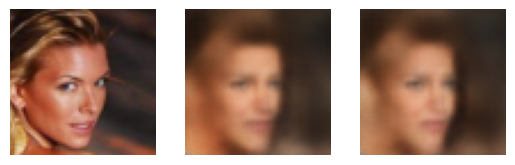

In [110]:
from tqdm.notebook import tqdm # status bar

num_epochs = 1

model.eval()
for epoch in range(num_epochs):
    for batch_idx, (images, _) in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            x_recon, mu, logvar = model(images)
            print(images.shape)

            # write encoding to file for later use
            torch.save({'mu': mu, 'logvar': logvar}, 'encoding.pt')
            #torch.save(model.encode(images), 'encoding.pt')
            data = torch.load('encoding.pt')
            test = model.decode(model.reparameterize(data['mu'],data['logvar']))

            fig, axes = plt.subplots(ncols=3)
            axes[0].imshow(images[0].squeeze().detach().permute(1,2,0))
            axes[0].axis('off')
            axes[1].imshow(x_recon[0].squeeze().detach().permute(1,2,0))
            axes[1].axis('off')
            axes[2].imshow(test[0].squeeze().detach().permute(1,2,0))
            axes[2].axis('off')
            plt.show()

            break

### Show my own face vs reconstruction

torch.Size([1, 3, 64, 64])


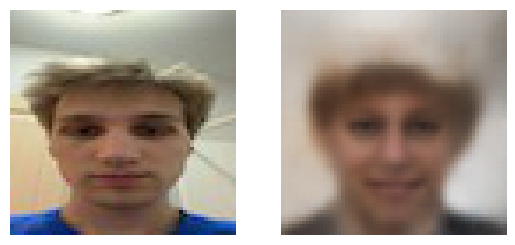

In [111]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Define the transform to resize the image and convert to tensor
transform = transforms.Compose([
#     transforms.Resize((64, 64)),  # resize to 64x64
    transforms.ToTensor()        # convert to tensor
])

# Load the image and apply the transform
drew = Image.open('/Users/drew/Downloads/drew.jpg').convert('RGB')
drew_tensor = transform(drew)

# Create a PyTorch DataLoader with batch size 1
batch_size = 1
drew_dl = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(drew_tensor),
    batch_size=batch_size,
    shuffle=False
)

model.eval()

print(drew_tensor.unsqueeze(0).shape)
x_recon, mu, logvar = model(drew_tensor.unsqueeze(0))

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(drew_tensor.squeeze().detach().permute(1,2,0))
axes[0].axis('off')
axes[1].imshow(x_recon.squeeze().detach().permute(1,2,0))
axes[1].axis('off')
plt.show()

# for epoch in range(num_epochs):
#     for batch_idx, image in enumerate(tqdm(drew_dl)):
        
#         print(image[-1].shape)
        
#         x_recon, mu, logvar = model(image[0])
        
#         fig, axes = plt.subplots(ncols=2)
#         axes[0].imshow(image[0].squeeze().detach().permute(1,2,0))
#         axes[0].axis('off')
#         axes[1].imshow(x_recon.squeeze().detach().permute(1,2,0))
#         axes[1].axis('off')
#         plt.show()
        
#         break

### Train on my face

In [ ]:
from tqdm.notebook import tqdm # status bar

num_epochs = 500

model.train()
for epoch in range(num_epochs):
        
    x_recon, mu, logvar = model(drew_tensor.unsqueeze(0))
    loss = loss_fn(x_recon, drew_tensor.unsqueeze(0), mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
              .format(epoch+1, num_epochs, batch_idx+1, len(dataloader), loss.item()))

# Save the trained VAE
# torch.save(model.state_dict(), model_path)

model.eval()

print(drew_tensor.unsqueeze(0).shape)
x_recon, mu, logvar = model(drew_tensor.unsqueeze(0))

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(drew_tensor.squeeze().detach().permute(1,2,0))
axes[0].axis('off')
axes[1].imshow(x_recon.squeeze().detach().permute(1,2,0))
axes[1].axis('off')
plt.show()